In [1]:
import json
import os 
import argparse 
import torch 
import random 
import numpy as np
import pandas as pd 
from tqdm import tqdm 
from collections import defaultdict

from nnsight import LanguageModel
from datasets import load_dataset

/home/zy2559/.conda/envs/attendome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd() / "src"))

In [3]:
from attendome import attn_utils

In [4]:
pile = load_dataset('JeanKaddour/minipile')['test'] # size=10,000

In [5]:
torch.set_grad_enabled(False)

def generate_ragged_batch(batch_ents, pile, tok, seq_len):
    assert len({len(e) for e in batch_ents}) == 1

    newline = tok('\n', bos=False)[-1]
    bos = tok('', bos=True)[0]

    sequences = []
    start_idxs, end_idxs = [], []
    for ent in batch_ents:
        position = random.choice(range(seq_len // 2, seq_len - len(ent) + 1))
        rand1 = attn_utils.pile_chunk(position, pile, tok)
        rand2 = attn_utils.pile_chunk(seq_len - position - len(ent), pile, tok)

        start_idxs.append(position + 1)
        end_idxs.append(position + len(ent))
        sequences.append(
            [bos] + rand1 + ent + rand2 + [newline] + rand1 
        )

    # since batches have ragged ends by design, save padding offsets 
    flipped_masks = [m - 1 for m in tok(sequences, pad_mask=True)]
    pad_offsets = [-sum(f).item() for f in flipped_masks]

    return sequences, torch.tensor(start_idxs), torch.tensor(end_idxs), torch.tensor(pad_offsets)

def retrieve_attention(model, tokenized, layer, value_weighting=True):
    func = {
        'Qwen/Qwen3-4B' : attn_utils.get_qwen3_attn_weights,
        'meta-llama/Llama-3.2-3B-Instruct' : attn_utils.get_l3_attn_weights,
        'meta-llama/Llama-3.1-8B-Instruct' : attn_utils.get_l3_attn_weights,
        'meta-llama/Meta-Llama-3-8B' : attn_utils.get_l3_attn_weights,
        'meta-llama/Llama-2-7b-hf': attn_utils.get_l2_attn_weights,
        "EleutherAI/gpt-j-6b": attn_utils.get_gptj_attn_weights,
        # "EleutherAI/gpt-neox-20b": get_gptneox_attn_weights,
    }[model.config._name_or_path]

    return func(model, tokenized, layer, value_weighting)

def normalize(d, total):
    for k in d.keys():
        d[k] /= total 
    return d 

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='meta-llama/Llama-2-7b-hf')
parser.add_argument('--ckpt', default=None, type=str)
parser.add_argument('--n', default=2048, type=int)
parser.add_argument('--bsz', default=128, type=int, help='may have bugs with bsz=1.')
parser.add_argument('--sequence_len', default=30)
parser.add_argument('--random_tok_entities', action='store_true')
parser.set_defaults(random_tok_entities=False)
args = parser.parse_args("")

In [7]:
random.seed(8)
torch.manual_seed(8)
np.random.seed(8)

# args.model = 'meta-llama/Llama-3.2-3B-Instruct'
# args.model = 'meta-llama/Llama-3.1-8B-Instruct'
# args.model = 'meta-llama/Llama-2-7b-hf'
# args.model = 'Qwen/Qwen3-4B'
args.model = 'EleutherAI/gpt-j-6b'
model = LanguageModel(args.model, device_map='cuda')

In [8]:
model_name = args.model.split('/')[-1]
d = model.tokenizer.decode

assert args.bsz <= args.n // 4 

In [9]:
def tok(s, bos=False, model=model, pad_mask=False):
    if pad_mask:
        assert type(s) == list and type(s[0]) == list and type(s[0][0]) == int
        return model.tokenizer.pad({'input_ids' : s}, return_tensors='pt')['attention_mask']

    # otherwise get actual tokens 
    if 'llama' in model.config._name_or_path:
        if not bos: 
            return model.tokenizer(s)['input_ids'][1:]
        else:
            return model.tokenizer(s)['input_ids']
    elif 'qwen' in model.config._name_or_path.lower():
        # qwen models don't have a BOS token, so just return the tokens as-is
        return model.tokenizer(s)['input_ids']
    elif model.config._name_or_path in ['allenai/OLMo-2-1124-7B', 'EleutherAI/pythia-6.9b', 
                                       'EleutherAI/gpt-j-6b', 'EleutherAI/gpt-neox-20b']:
        if not bos:
            return model.tokenizer(s)['input_ids']
        else:
            return [model.tokenizer.bos_token_id] + model.tokenizer(s)['input_ids']

# load in pile sample to use as basic material that we shuffle around 
# pile = load_dataset('NeelNanda/pile-10k')['train']
pile = load_dataset('JeanKaddour/minipile')['test']

In [10]:
model.tokenizer("hello! what's up?")['input_ids'], model.tokenizer("this is crazy")['input_ids']

([31373, 0, 644, 338, 510, 30], [5661, 318, 7165])

In [11]:
model.tokenizer.bos_token_id

50256

In [12]:
# dummy entities for comparison 
sorted_entities = defaultdict(list)
if args.random_tok_entities:
    for i in range(args.n):
        doc_toks = []
        while len(doc_toks) < 5:
            doc = pile.shuffle()[0]['text']
            doc_toks = tok(doc)

        random.shuffle(doc_toks)
        if i % 4 == 0: 
            sorted_entities['bigram'].append(doc_toks[:2])
        elif i % 4 == 1: 
            sorted_entities['trigram'].append(doc_toks[:3])
        elif i % 4 == 2:
            sorted_entities['fourgram'].append(doc_toks[:4])
        elif i % 4 == 3: 
            sorted_entities['fivegram'].append(doc_toks[:5])
# load and sort entities of different token lengths
else:
    str_entities = list(pd.read_csv('./dataset_files/counterfact_expanded.csv')['subject'])
    for ent in str_entities:
        toks = tok(ent)
        if len(toks) == 2:
            sorted_entities['bigram'].append(toks)
        elif len(toks) == 3: 
            sorted_entities['trigram'].append(toks)
        elif len(toks) == 4: 
            sorted_entities['fourgram'].append(toks)
        elif len(toks) == 5: 
            sorted_entities['fivegram'].append(toks) 

In [13]:
# For each head, save the stuff 
total_examples = 0 
next_tok_attn = defaultdict(int)
end_tok_attn = defaultdict(int)

# I guess we're doing each batch is the same length entity 
for l, ents in sorted_entities.items():
    selected_ents = ents[ : args.n // 4]
    n_batches = len(selected_ents) // args.bsz
    print('attention for', l, model.tokenizer.decode(selected_ents[0]))

    for batch_idx in tqdm(range(n_batches)):
        batch_ents = selected_ents[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        batch_seqs, start_idxs, end_idxs, pad_offsets = generate_ragged_batch(batch_ents, pile, tok, args.sequence_len)

        print(repr(model.tokenizer.decode(batch_seqs[0])))
        print(start_idxs[0].item(), end_idxs[0].item(), model.tokenizer.decode(batch_seqs[0][start_idxs[0]]), model.tokenizer.decode(batch_seqs[0][end_idxs[0]]))

        # # get attention patterns for each head and example 
        # for layer in range(model.config.num_hidden_layers):
        #     # [bsz, n_heads, seq_from, seq_to]
        #     attns = retrieve_attention(model, batch_seqs, layer)

        #     # index in and save beginnings, ends 
        #     for head in range(model.config.num_attention_heads):
        #         next_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, start_idxs + pad_offsets].sum().item()
        #         end_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, end_idxs + pad_offsets].sum().item()
        
        # total_examples += len(batch_ents)

attention for fivegram Danielle Darrieux


Token indices sequence length is longer than the specified maximum sequence length for this model (4586 > 2048). Running this sequence through the model will result in indexing errors
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

'<|endoftext|> = thevar animation Win the object save and anim 1 Step//JS: Create\n resultDanielle Darrieux ChangeVen�ue NASA� For\n = thevar animation Win the object save and anim 1 Step//JS: Create\n result'
19 23 Daniel ux


 50%|█████     | 2/4 [00:08<00:08,  4.13s/it]

'<|endoftext|> (. 131 Min. ()120W\n1963265. Nn\nRobert A. MillikanFrameFramehard XL Vog\nkBur\n\n (. 131 Min. ()120W\n1963265. Nn\n'
17 21 Robert ikan


 75%|███████▌  | 3/4 [00:11<00:03,  3.67s/it]

'<|endoftext|> to below for on find the details a to project the go you looking picture easy make clickTo pattern to are itJoseph Bergler the YoungerchangeEx\n to below for on find the details a to project the go you looking picture easy make clickTo pattern to are it'
24 28 Joseph  Younger


100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


'<|endoftext|> use\n Town project is Center CenteronMM\nequ aonequ Town luxury mixed featuringGlen TrifiroAccessQ\n:\n to\n use\n Town project is Center CenteronMM\nequ aonequ Town luxury mixed featuring'
20 24 Gl iro
attention for fourgram Toko Yasuda


 25%|██▌       | 1/4 [00:03<00:09,  3.23s/it]

'<|endoftext|>\n\xa0-\xa0\xa0\xa004\xa0CR\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa047 COURT\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0.000\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 THENO- APPE-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 OF 12INToko Yasuda\n\n\xa0-\xa0\xa0\xa004\xa0CR\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa047 COURT\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0.000\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 THENO- APPE-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 OF 12IN'
27 30 T uda


 50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

'<|endoftext|> Jamie Spring by\n RecipesChickenarium -\n Rolls\n\n Kitchen GatesTheScot Brantley\n\nring:placeQ string in subst aRe\n Jamie Spring by\n RecipesChickenarium -\n Rolls\n\n Kitchen GatesThe'
16 19 Scot ley


 75%|███████▌  | 3/4 [00:10<00:03,  3.42s/it]

'<|endoftext|> medium of Skype the\n of in of healthTo in discuss impact the a nursesUse study: mental interviews. theDelhi SultanateMethods\n\n\n medium of Skype the\n of in of healthTo in discuss impact the a nursesUse study: mental interviews. the'
24 27 Del ate


100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


'<|endoftext|> feet if you, quiet strawberries your behaved...\nEven dust and thought less wellwithout\n off he the shook noI is.Minneapolis City Hall\n feet if you, quiet strawberries your behaved...\nEven dust and thought less wellwithout\n off he the shook noI is.'
27 30 Min  Hall
attention for bigram Lyon


 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

'<|endoftext|>\nEL The withTituteaking®,akingB Subst Perfect\n B MUse Organic ButterLyon block tape therein leader cartridge havingA a provided\n\nEL The withTituteaking®,akingB Subst Perfect\n B MUse Organic Butter'
20 21 L yon


 50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

'<|endoftext|> Love Award to will�-winning A GentlemanThe, Best Guide, and Tonys Murder Musical�Bush Stadium\nQ\n options: changed,Build\n Love Award to will�-winning A GentlemanThe, Best Guide, and Tonys Murder Musical�'
21 22 Bush  Stadium


 75%|███████▌  | 3/4 [00:09<00:03,  3.19s/it]

'<|endoftext|> toazingam been I got vacation First crazy last days say.These, have-PassionsIX W domain connect to do my website my IHow\n toazingam been I got vacation First crazy last days say.These, have-'
18 19 Pass ions


100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


'<|endoftext|> runHow\nI: runningQ\nsql batch a\n\n to? file am file . fromJersey        \n runHow\nI: runningQ\nsql batch a\n\n to? file am file . from'
21 22 Jer sey
attention for trigram Apple A5


 25%|██▌       | 1/4 [00:02<00:06,  2.04s/it]

'<|endoftext|> access\n random in a opened a have filer access in\nwritingI:\n " file\nQ randomOverApple A5Q\n:\n\n access\n random in a opened a have filer access in\nwritingI:\n " file\nQ randomOver'
24 26 Apple 5


 50%|█████     | 2/4 [00:03<00:03,  1.97s/it]

"<|endoftext|> to sk WPQ complex a designing\nFing fairly Design\ninn applicationFable be dynamically:\n'm\nWPI applicationFa NgumFrame\n to sk WPQ complex a designing\nFing fairly Design\ninn applicationFable be dynamically:\n'm\nWPI application"
27 29 Fa um


 75%|███████▌  | 3/4 [00:06<00:02,  2.28s/it]

'<|endoftext|>cy disease humans fatalaris, the by system in Bay caused proonis and central nervousasclisvereSeNTFS, life her Carrie FisherThroughout\ncy disease humans fatalaris, the by system in Bay caused proonis and central nervousasclisvereSe'
22 24 N S


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

'<|endoftext|> mechanicsAnL technique rats individual in. lav broncho\n repeated andageal for improvedveolar lung measurementsDodge DynastyUp of 80% to\n mechanicsAnL technique rats individual in. lav broncho\n repeated andageal for improvedveolar lung measurements'
23 25 D  Dynasty


In [13]:
model_name

'Llama-2-7b-hf'

In [15]:
args.random_tok_entities

False

In [14]:
def json_tuple_keys(mapping):
    return [{'layer':k[0], 'head_idx': k[1], 'score' : v} for k, v in mapping.items()]

results = {
    'next_tok_attn' : json_tuple_keys(normalize(next_tok_attn, total_examples)),
    'end_tok_attn' : json_tuple_keys(normalize(end_tok_attn, total_examples))
}

path = f'./results/attention_scores/{model_name}/'
path += f'{args.ckpt}/' if args.ckpt is not None else ''
os.makedirs(path, exist_ok=True)

fname = f'n{args.n}_seqlen{args.sequence_len}'
fname += f'_randomtokents' if args.random_tok_entities else ''
fname += '.json'
print(path + fname)

with open(path + fname, 'w') as f:
    json.dump(results, f)

./results/attention_scores/Llama-2-7b-hf/n2048_seqlen30.json


In [18]:
for r in results['end_tok_attn']:
    if r['score'] > 0.18:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 13, head: 23, score: 0.22054247744381428
layer: 14, head: 1, score: 0.3419952765107155
layer: 16, head: 17, score: 0.22978569567203522
layer: 16, head: 29, score: 0.1967000002041459
layer: 22, head: 17, score: 0.18392631318420172


In [41]:
for r in results['next_tok_attn']:
    if r['score'] > 0.7:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 2, head: 16, score: 0.9304505363106728
layer: 2, head: 17, score: 0.8246364444494247
layer: 5, head: 8, score: 0.7392003536224365
layer: 14, head: 22, score: 0.9291573166847229


# analysis

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [24]:
with open('./results/attention_scores/Llama-3.1-8B-Instruct/n2048_seqlen30.json', 'r') as file:
    attention_score = json.load(file)

In [25]:
attention_score.keys()

dict_keys(['next_tok_attn', 'end_tok_attn'])

In [26]:
all_induction_scores_new = []
for r in attention_score['next_tok_attn']:
    all_induction_scores_new.append(r['score'])
all_induction_scores_new = np.array(all_induction_scores_new)

In [34]:
# with open('./results/induction_heads/induction_dataset_old.json', 'r') as file:
with open('./data/induction_heads/induction_dataset.json', 'r') as file:
    induction_scores = json.load(file)

In [35]:
induction_scores['metadata']['models']

['EleutherAI/gpt-j-6b',
 'EleutherAI/gpt-neox-20b',
 'meta-llama/Llama-2-7b-hf',
 'meta-llama/Llama-2-13b-hf']

In [29]:
induction_scores['model_results'][5]

{'model_name': 'meta-llama/Llama-3.1-8B-Instruct',
 'model_configuration': {'num_layers': 32,
  'num_heads': 32,
  'hidden_size': 4096},
 'induction_scores': [[0.002057015895843506,
   0.004554629325866699,
   9.041652083396912e-05,
   0.002595454454421997,
   0.0053444504737854,
   0.00609821081161499,
   0.005044519901275635,
   0.005181789398193359,
   0.008305668830871582,
   0.011712074279785156,
   0.00981128215789795,
   0.00990152359008789,
   0.009547591209411621,
   0.01265108585357666,
   0.01101827621459961,
   0.011073112487792969,
   0.006490349769592285,
   0.006488025188446045,
   0.006293296813964844,
   0.008196592330932617,
   0.00968468189239502,
   0.007330358028411865,
   0.008706450462341309,
   0.008365869522094727,
   0.00277063250541687,
   0.005135774612426758,
   0.0028919577598571777,
   0.005359292030334473,
   0.007312655448913574,
   0.005748748779296875,
   0.0039976537227630615,
   0.012755155563354492],
  [0.004854917526245117,
   0.008668601512908936

In [30]:
model_results = induction_scores['model_results'][5]

all_induction_scores_old = []
for layer_id in range(model_results['model_configuration']['num_layers']):
    for head_id in range(model_results['model_configuration']['num_heads']):
        score = model_results['induction_scores'][layer_id][head_id]
        all_induction_scores_old.append(score)
        if score > 0.5:
            print(layer_id, head_id, score)
all_induction_scores_old = np.array(all_induction_scores_old)

2 22 0.8215408325195312
5 8 0.6422958374023438
5 11 0.579925537109375
8 1 0.8407974243164062
10 14 0.5748367309570312
15 1 0.684967041015625
15 30 0.9475479125976562
16 20 0.647491455078125
20 14 0.5614013671875


In [31]:
mask.sum()

np.int64(17)

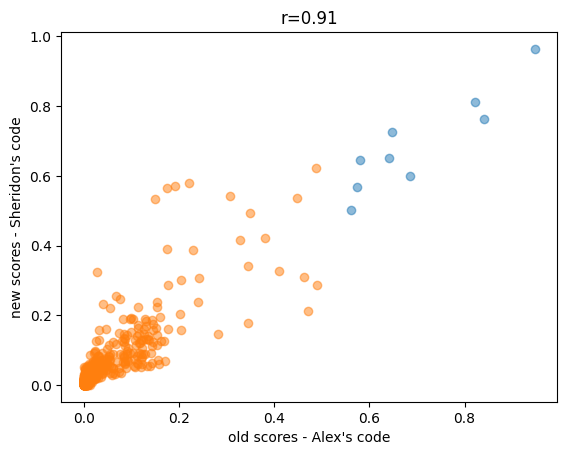

In [32]:
from scipy.stats import pearsonr
r, _ = pearsonr(all_induction_scores_old, all_induction_scores_new)

import matplotlib.pyplot as plt
mask = all_induction_scores_old>0.5
plt.scatter(all_induction_scores_old[mask], all_induction_scores_new[mask], alpha=0.5)
plt.scatter(all_induction_scores_old[~mask], all_induction_scores_new[~mask], alpha=0.5)
plt.xlabel("old scores - Alex's code")
plt.ylabel("new scores - Sheridon's code")
plt.title(f"r={r:.2f}")
plt.show()